Влияние площади ресторана

In [1]:
import requests
import pandas as pd

url = 'https://lodmedia.hb.bizmrg.com/case_files/1059645/train_dataset_hackaton2023_train.gzip'
response = requests.get(url)

if response.status_code == 200:
    with open('file', 'wb') as file:
        file.write(response.content)
else:
    print('Ошибка при загрузке файла')

df = pd.read_parquet('file')

df

,customer_id,date_diff_post,buy_post,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
0,29891,9.0,1,train,69.99,2022-12-05 12:03:58,Кинг Фри станд,300.0,Отдельно стоящий без внешней зоны
1,29891,9.0,1,train,190.00,2022-12-05 12:03:58,Чикен Тар-Тар,300.0,Отдельно стоящий без внешней зоны
2,29891,9.0,1,train,9.99,2022-12-05 12:03:58,Соус Сырный,300.0,Отдельно стоящий без внешней зоны
3,29891,9.0,1,train,119.99,2022-12-05 12:03:58,Энергет.нап. Адреналин Раш,300.0,Отдельно стоящий без внешней зоны
4,29891,9.0,1,train,119.99,2022-12-05 14:28:35,Латте (СТАНД.),300.0,Отдельно стоящий без внешней зоны
...,...,...,...,...,...,...,...,...,...
24261974,46661804,NaN,0,train,7.99,2023-08-01 18:04:56,"Эвервесс Кола джун 0,3л",300.0,Фудкорт с туалетом
24261975,46661804,NaN,0,train,84.98,2023-08-01 18:04:56,Воппер Джуниор,300.0,Фудкорт с туалетом
24261976,46661804,NaN,0,train,70.03,2023-08-01 18:04:56,Наггетсы (3 шт.),300.0,Фудкорт с туалетом
24261977,46661804,NaN,0,train,19.00,2023-08-01 18:04:56,Сырные Медальоны (3 шт.),300.0,Фудкорт с туалетом


In [2]:
#Проверка влияния площади заведения
df = df.drop(columns=['group_name', 'date_diff_post', 'dish_name', 'revenue', 'format_name'])

df.dtypes

customer_id                int64
buy_post                   int64
startdatetime     datetime64[ns]
ownareaall_sqm           float64
dtype: object

In [3]:
#df['startdatetime'] = df['startdatetime'].dt.round('min')
df = df.drop_duplicates(subset=['customer_id', 'startdatetime'], keep='last')
df

,customer_id,buy_post,startdatetime,ownareaall_sqm
3,29891,1,2022-12-05 12:03:58,300.0
4,29891,1,2022-12-05 14:28:35,300.0
6,29891,1,2022-12-15 00:37:19,463.0
7,29891,1,2022-12-20 09:20:38,463.0
8,29891,1,2022-12-21 09:46:23,463.0
...,...,...,...,...
24261961,46654016,1,2023-08-01 14:04:28,270.0
24261963,46654016,1,2023-08-01 18:15:31,270.0
24261966,46661804,0,2023-08-01 17:50:26,300.0
24261972,46661804,0,2023-08-01 18:01:40,300.0


In [4]:
# !pip install -U fastapi
# !pip install -U python-multipart
# !pip install -U uvicorn
# !pip install -U kaleido
# import plotly.express as px
# import plotly.io as pio

# pio.renderers
# pio.renderers.default = "png"

#Зависимость площадь / человеки не особо
#Зависимость площадь / посещения - есть, но скорее всего тут больше влияние числа посещений

import plotly.express as px

fig = px.histogram(
    df,
    x="ownareaall_sqm",
    color="buy_post",
    marginal="box",
    width=1000,
    height=800,
    title="Распределение числа посещений площадок по площади (без корректировки)",
    barmode='overlay',
)
fig.show()


In [5]:
# Возможно, есть такие точки, которые 0, 979, но нам только данные забивают, поэтому отсекаем по усам
df = df[df['ownareaall_sqm'] > 0]
df = df[df['ownareaall_sqm'] < 540]

fig = px.histogram(
    df,
    x="ownareaall_sqm",
    color="buy_post",
    marginal="box",
    width=1000,
    height=800,
    title="Распределение числа посещений площадок по площади (с корректировкой)",
    barmode='overlay',
)
fig.show()


In [6]:
#Площадки делятся на большие и маленьки где-то по границе 180
import numpy as np

df['size'] = np.where(df['ownareaall_sqm']>180, 1, 0) # 1 - большой,  0 - маленький

fig = px.histogram(
    df,
    x="size",
    color="buy_post",
    marginal="box",
    width=1000,
    height=800,
    title="Распределение числа посещений площадок по площади (с корректировкой)",
    barmode='overlay',
)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [15]:

df_feat = df.groupby(['customer_id', 'buy_post', 'size'], as_index=True).agg({"size": ["count"]})
df_feat.columns = ["visits"]
df_feat.reset_index(inplace=True)
df_feat['feat'] = np.where(df_feat['size']==1, 0.99**df_feat['visits'], 1)
df_feat = df_feat.groupby(['customer_id', 'buy_post', 'feat'], as_index=True).agg({"feat": ["min"]})
df_feat.columns = ["feat_min"]
df_feat.reset_index(inplace=True)
df_feat['feat_min'] = 1 - df_feat['feat_min']
fig = px.histogram(
    df_feat,
    x="feat_min",
    color="buy_post",
    marginal="box",
    width=1000,
    height=800,
    title="Распределение числа посещений площадок по площади (с корректировкой)",
    barmode='overlay',
)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [16]:
# фича так себе

def calculate_information_value(dataset, feats, target_col):
    iv_by_feat = {}
    temp = dataset.copy()
    for feat in ['feat']:
        temp["quant_range"] = pd.qcut(
            x=temp['feat'], q=[0, 0.25, 0.5, 0.75, 1.0], duplicates="drop"
        )

        bins = {}
        for i, bin in enumerate(temp["quant_range"].unique()):
            bins[bin] = i

        temp["bin"] = temp["quant_range"].apply(lambda x: bins[x])

        iv = (
            pd.crosstab(temp["bin"], temp[target_col], normalize="columns")
            .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
            .assign(iv=lambda dfx: np.sum(dfx["woe"] * (dfx[1] - dfx[0])))
        )["iv"].unique()[0]

        iv_by_feat[feat] = [iv]
    df = pd.DataFrame(iv_by_feat).T
    df.reset_index(inplace=True)
    df.columns = ["feature", "IV"]
    return df

calculate_information_value(df_feat, ["feat"], 'buy_post')

,feature,IV
0,feat,0.011328


Временные характеристики

In [ ]:
df = pd.read_parquet('file')

df = df.drop(columns=['group_name', 'date_diff_post', 'dish_name', 'revenue', 'format_name', 'ownareaall_sqm'])

df = df.drop_duplicates(subset=['customer_id', 'startdatetime'], keep='last')
df['startdatetime'] = df['startdatetime'].dt.round('H')
df['time'] = df['startdatetime'].dt.time
# df['buy_post'] = df['buy_post'].astype('category')
# df['startdatetime'] = df['startdatetime'].astype('str').str.replace(':', '').astype('int64')

df = df.sort_values(by=['time', 'buy_post'])
df = df.drop(columns=['startdatetime'])
# df_sum_agg = df.groupby(['time', 'buy_post'], as_index=True).agg({"time": ["count"]})
# df_sum_agg.columns = ["peoples_count"]
# df_sum_agg.reset_index(inplace=True)

fig = px.histogram(
    df,
    x="time",
    color="buy_post",
    marginal="box",
    width=1000,
    height=800,
    title="Распределение числа посещений площадок по времени (без корректировки)",
    barmode='overlay',
)
fig.show()

# fig = px.box(df, x="buy_post", y="startdatetime")
# fig.show()

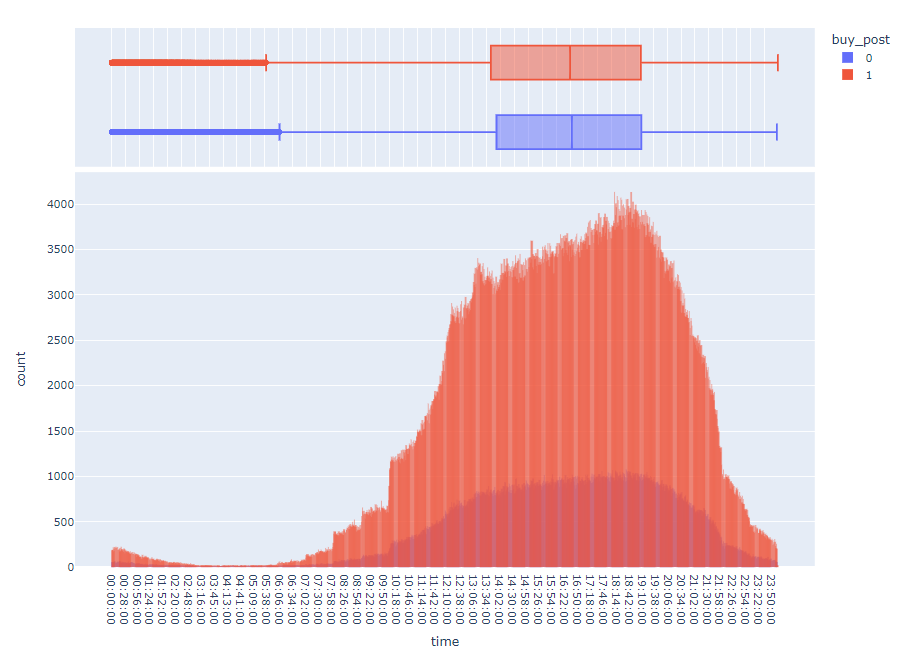

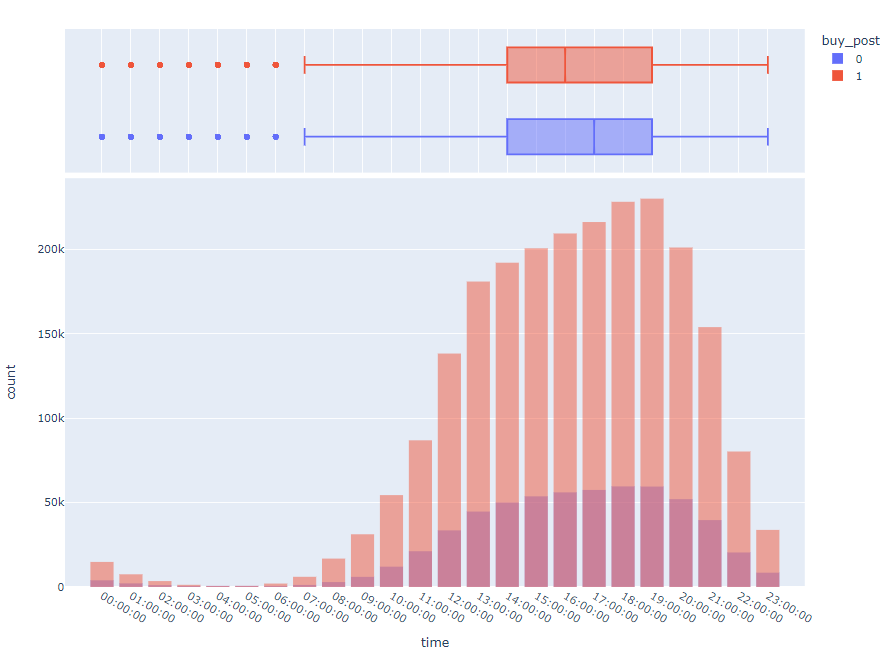

In [25]:
df = df.sort_values(by=['time', 'buy_post'])
df

,customer_id,buy_post,time
5304,196502,0,00:00:00
5313,196502,0,00:00:00
25430,214859,0,00:00:00
29377,216371,0,00:00:00
54496,228438,0,00:00:00
...,...,...,...
24257809,46336787,1,23:00:00
24257890,46341065,1,23:00:00
24260516,46481424,1,23:00:00
24260858,46509132,1,23:00:00
